# DCGAN sobre CIFAR-10 en PyTorch

Este notebook implementa un DCGAN básico: definimos generador y discriminador, entrenamos adversarialmente y visualizamos muestras.

## 1. Instalación
```python
!pip install torch torchvision matplotlib --quiet
```

In [1]:
!pip install torch torchvision matplotlib --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Carga de datos CIFAR-10

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_ds = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
dl = DataLoader(train_ds, batch_size=128, shuffle=True)
print(f'Train samples: {len(train_ds)}')

Train samples: 50000


## 3. Definición del Generador y Discriminador

In [4]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            # z -> 512x4x4
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0),
            nn.BatchNorm2d(512), nn.ReLU(True),
            # 512x4x4 -> 256x8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.ReLU(True),
            # 256x8x8 -> 128x16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(True),
            # 128x16x16 -> 3x32x32
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 3x32x32 -> 128x16x16
            nn.Conv2d(3, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            # 128x16x16 -> 256x8x8
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            # 256x8x8 -> 512x4x4
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            # 512x4x4 -> 1x1x1
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)

# Instanciar y mostrar
G = Generator(z_dim=100)
D = Discriminator()
print(G)
print(D)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Co

## 4. Entrenamiento adversarial (1 paso)

In [5]:
import torch.optim as optim

# Preparación de dispositivos y optimizadores
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G, D = G.to(device), D.to(device)
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Un batch de reales
real_imgs, _ = next(iter(dl))
real_imgs = real_imgs.to(device)
b_size = real_imgs.size(0)

# Labels
real_labels = torch.ones(b_size, device=device)
fake_labels = torch.zeros(b_size, device=device)

# Entrenar D con reales
opt_D.zero_grad()
# Loss con reales
output_real = D(real_imgs)
loss_D_real = criterion(output_real, real_labels)

# Entrenar D con fake
z = torch.randn(b_size, 100, 1, 1, device=device)
fake_imgs = G(z)
output_fake = D(fake_imgs.detach())
loss_D_fake = criterion(output_fake, fake_labels)

# Backprop y paso
loss_D = loss_D_real + loss_D_fake
loss_D.backward()
opt_D.step()

# Entrenar G
opt_G.zero_grad()
output_fake2 = D(fake_imgs)
loss_G = criterion(output_fake2, real_labels) # intenta “engañar” a D
loss_G.backward()
opt_G.step()

print(f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

Loss D: 1.4752, Loss G: 5.0047


## 5. Generación de muestras

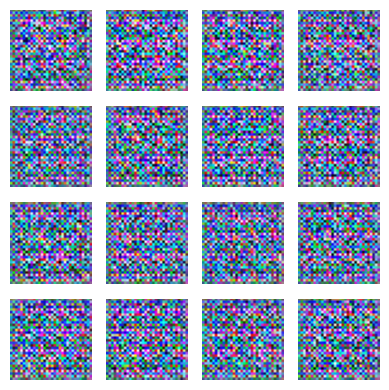

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Generar un grid 4x4
with torch.no_grad():
    z = torch.randn(16, 100, 1, 1, device=device)
    samples = G(z).cpu() * 0.5 + 0.5  # desnormalizar

fig, axs = plt.subplots(4, 4, figsize=(4,4), tight_layout=True)
for ax, img in zip(axs.flatten(), samples):
    npimg = img.permute(1,2,0).numpy()
    ax.imshow(npimg)
    ax.axis('off')
plt.show()

Epoch [1/30]  Loss_D: 0.3636  Loss_G: 13.7095
Epoch [2/30]  Loss_D: 0.1748  Loss_G: 12.5359


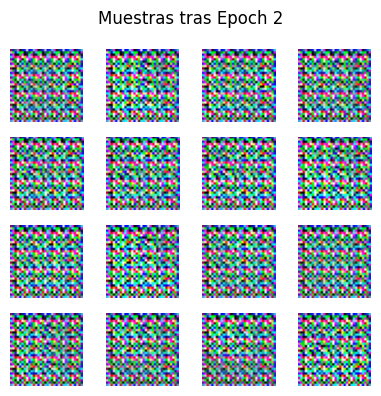

Epoch [3/30]  Loss_D: 0.1189  Loss_G: 7.0959
Epoch [4/30]  Loss_D: 0.5435  Loss_G: 4.6152


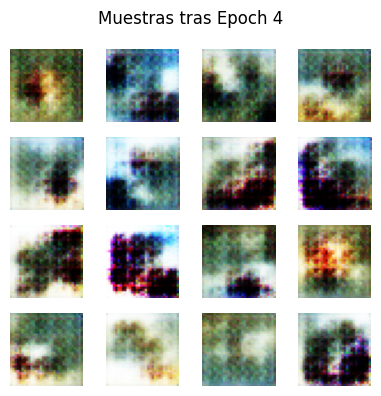

Epoch [5/30]  Loss_D: 0.6672  Loss_G: 3.8194
Epoch [6/30]  Loss_D: 0.5711  Loss_G: 4.0336


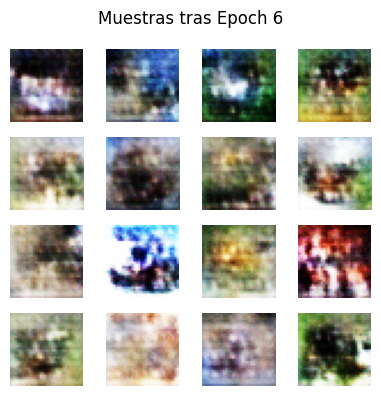

Epoch [7/30]  Loss_D: 0.4995  Loss_G: 4.4634
Epoch [8/30]  Loss_D: 0.4855  Loss_G: 4.8018


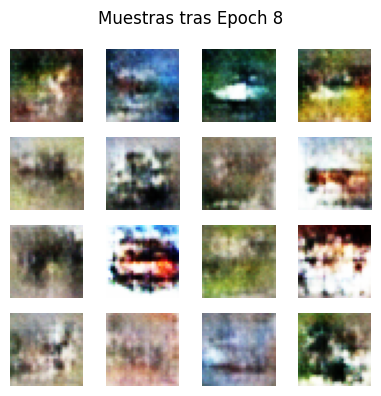

Epoch [9/30]  Loss_D: 0.4230  Loss_G: 4.8285
Epoch [10/30]  Loss_D: 0.3694  Loss_G: 5.6304


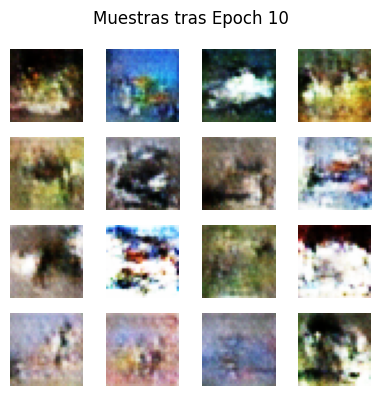

Epoch [11/30]  Loss_D: 0.2871  Loss_G: 5.8890
Epoch [12/30]  Loss_D: 0.3841  Loss_G: 5.8694


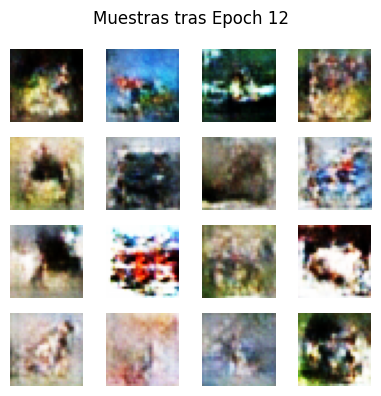

Epoch [13/30]  Loss_D: 0.2546  Loss_G: 5.9485
Epoch [14/30]  Loss_D: 0.2475  Loss_G: 6.1607


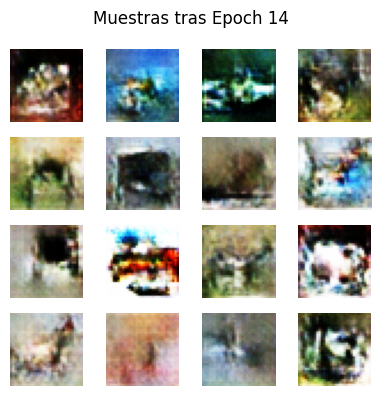

Epoch [15/30]  Loss_D: 0.2601  Loss_G: 5.8843
Epoch [16/30]  Loss_D: 0.2264  Loss_G: 5.9254


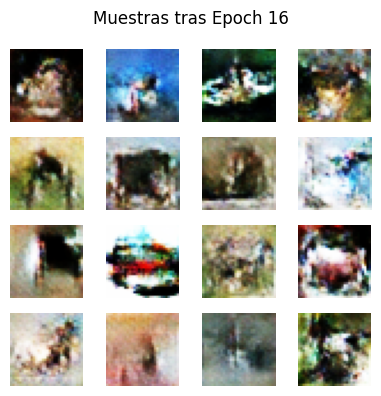

Epoch [17/30]  Loss_D: 0.1523  Loss_G: 6.3006
Epoch [18/30]  Loss_D: 0.2670  Loss_G: 5.5588


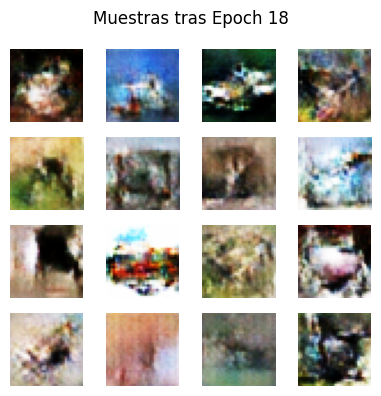

Epoch [19/30]  Loss_D: 0.1721  Loss_G: 5.8986
Epoch [20/30]  Loss_D: 0.1804  Loss_G: 6.0314


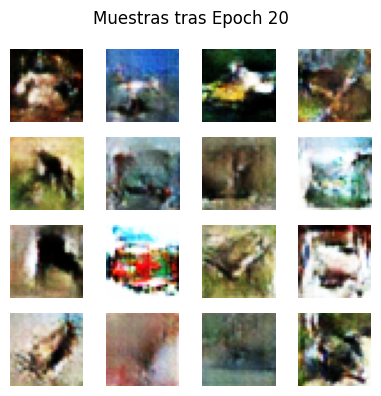

Epoch [21/30]  Loss_D: 0.1826  Loss_G: 5.9622
Epoch [22/30]  Loss_D: 0.1992  Loss_G: 5.9254


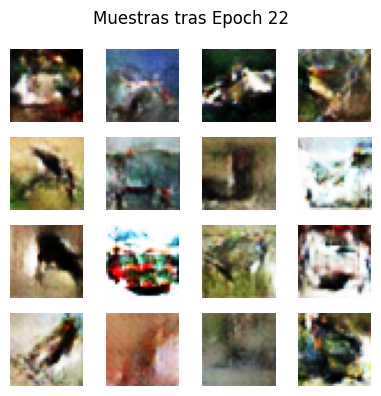

Epoch [23/30]  Loss_D: 0.1517  Loss_G: 5.8710
Epoch [24/30]  Loss_D: 0.2800  Loss_G: 5.4217


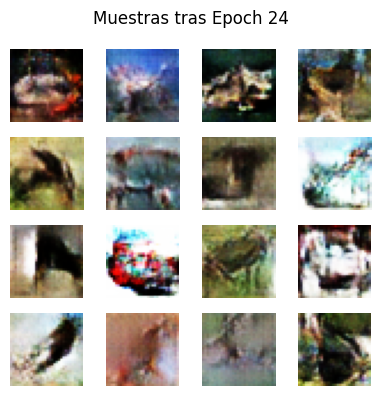

Epoch [25/30]  Loss_D: 0.2549  Loss_G: 5.1624
Epoch [26/30]  Loss_D: 0.1532  Loss_G: 5.5296


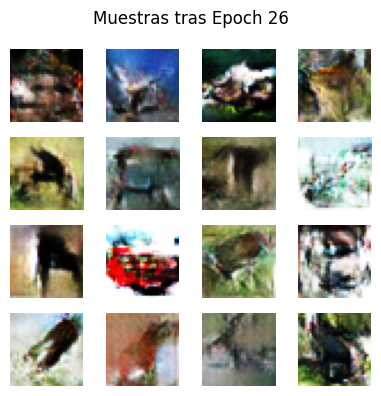

Epoch [27/30]  Loss_D: 0.2428  Loss_G: 5.5161
Epoch [28/30]  Loss_D: 0.3012  Loss_G: 5.1601


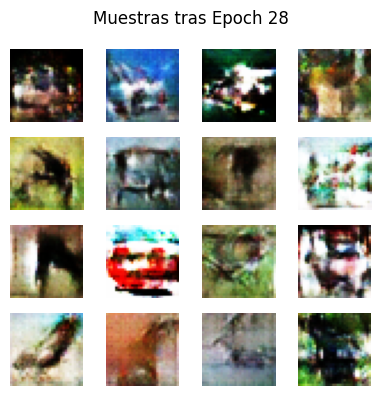

Epoch [29/30]  Loss_D: 0.2381  Loss_G: 5.2260
Epoch [30/30]  Loss_D: 0.1367  Loss_G: 5.3622


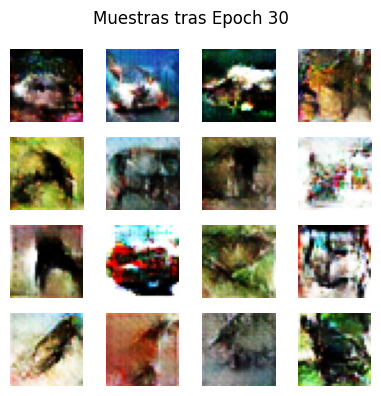

In [7]:
import torch.optim as optim
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G, D = G.to(device), D.to(device)
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_z = torch.randn(16, 100, 1, 1, device=device)

num_epochs = 30  # Puedes ajustar este número
for epoch in range(1, num_epochs + 1):
    loss_D_epoch = 0.0
    loss_G_epoch = 0.0
    for real_imgs, _ in dl:
        real_imgs = real_imgs.to(device)
        b_size = real_imgs.size(0)
        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        # — Actualizar Discriminador —
        opt_D.zero_grad()
        output_real = D(real_imgs)
        loss_D_real = criterion(output_real, real_labels)
        z = torch.randn(b_size, 100, 1, 1, device=device)
        fake_imgs = G(z)
        output_fake = D(fake_imgs.detach())
        loss_D_fake = criterion(output_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        opt_D.step()

        # — Actualizar Generador —
        opt_G.zero_grad()
        output = D(fake_imgs)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        opt_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    # Reportar pérdidas promedio
    print(f"Epoch [{epoch}/{num_epochs}]  "
          f"Loss_D: {loss_D_epoch/len(dl):.4f}  "
          f"Loss_G: {loss_G_epoch/len(dl):.4f}")

    # Mostrar muestras cada 2 épocas
    if epoch % 2 == 0:
        with torch.no_grad():
            samples = G(fixed_z).cpu() * 0.5 + 0.5
        fig, axs = plt.subplots(4, 4, figsize=(4,4), tight_layout=True)
        for ax, img in zip(axs.flatten(), samples):
            ax.imshow(img.permute(1,2,0).numpy())
            ax.axis('off')
        plt.suptitle(f'Muestras tras Epoch {epoch}')
        plt.show()